# Propagating the learnt model from PySINDy - Equinoctial

In [10]:
import numpy as np
from scipy.integrate import odeint

import matplotlib.pyplot as plt

from src.utils import *
from src.propagation import *


From the PySINDy learning, we have the following formula as the output

$$ F_R = 0.75 \frac{2(\sin{(u)}\sin{(i)})^2 -  (\cos{(u)}\sin{(i)})^2 -  \cos^2{(i)}}{r^4} = 0.75 \frac{8 (\sin{L} - k \cos{L})^2 -  4 (h \cos{L} + k \sin{L})^2 -  (1-h^2-k^2)^2}{s^2 r^4}  $$
$$ F_S = -1.5 \frac{\sin{(u)}\sin{(i)}\cos{(u)}\sin{(i)}}{r^4} = -6\frac{(\sin{L} - k \cos{L})(h \cos{L} + k \sin{L})}{s^2 r^4}$$
$$ F_W =  -1.5 \frac{\sin{(u)}\sin{(i)} \cos^2{(i)}}{r^4}=-3 \frac{(\sin{L} - k \cos{L})(1-h^2-k^2)}{s^2 r^4}$$

We will input these manually into the propagator.

## Propagation and comparison with training set

In [11]:
## Parameters
mu = 3.986004414498200e14 # Central Body's gravitational constant (m^3/s^2)
Re = 6.378136460000000e6 # Central Body's equatorial radius (m)

T_dim = np.sqrt(Re**3 / mu)  # Time unit for non-dimensionalization (s)
L_dim = Re  # Length unit for non-dimensionalization (m)

In [12]:
## Initial Condition
r0 = np.array([[3762519.374555595,7653889.605494166,4920134.758261914]]) # Initial position (m)
v0 = np.array([[1634.5155553226564,-2724.4575287820444,6196.075069155325]]) # Initial velocity (m/s)

equi0 = ijk2equinoctial(r0,v0,mu) # Transform initial state to initial Equinoctial elements
equi0[0,0] = equi0[0,0] / L_dim  # Non-dimensionalize semi-parameter by Re

## Time interval to integrate
t = np.linspace(0, 315360.0, 315360) / T_dim  # time (s)

# Deploy trained PySINDy models for force prediction in RSW coordinates
def F_RSW_PySINDy(equi, mu, Re):
    # Unpack equinoctial elements
    p_, f_, g_, h_, k_, L_ = equi
    # Since we've formulated some of the feature manually, we need to recompute them here
    # to pass them here again
    s_ = 1 + h_**2 + k_**2
    w_ = 1 + f_ * np.cos(L_) + g_ * np.sin(L_)
    r_val_ = p_ / w_
    sin_u_sin_i_ = 2 * (h_ * np.sin(L_) - k_ * np.cos(L_)) / s_
    cos_u_sin_i_ = 2 * (h_ * np.cos(L_) + k_ * np.sin(L_)) / s_
    cos_i_ = (1 - h_**2 - k_**2) / s_
    
    FR = 0.75 * (2 * (sin_u_sin_i_)**2 - (cos_u_sin_i_)**2 - (cos_i_)**2) / r_val_**4
    FS = -1.5 * (sin_u_sin_i_) * (cos_u_sin_i_) / r_val_**4
    FW = -1.5 * (sin_u_sin_i_) * (cos_i_) / r_val_**4
    return np.array([FR, FS, FW])


F_RSW = lambda equi: F_RSW_PySINDy(equi, 1, 1) # Non-dimensionalized mu and Re (both = 1 in non-dimensional units

# Function to transform Force in RSW into time derivative of Equinoctial elements
#                     d (equi)/ dt = A(equi,mu) * F_RSW(equi) + b(equi,mu)
dequi_dt = lambda equi, t: (RSW2equi_A(equi,1) @ F_RSW(equi) + RSW2equi_b(equi,1))

# Feed the time derivative of Equinoctial elements (as a function of the Equinoctial elements) into the ODE solver
sol = odeint(dequi_dt, equi0[0], t, rtol=1e-10) # Might take 1-2 minutes to run

### Comparison with the training set

In [13]:
import pandas as pd
# Load the CSV file with correct column extraction
# Assuming the first column is time, next three are position (r1, r2, r3), last three are velocity (v1, v2, v3)
df = pd.read_csv('./data/Challenge1.csv', header=0, usecols=[0,1,2,3,4,5,6], names=['time','r1', 'r2', 'r3', 'v1', 'v2', 'v3'])

# Extract position and velocity arrays
# Convert time strings to pandas datetime
t_raw = pd.to_datetime(df['time'])
# Calculate seconds relative to the first time point
t_data = (t_raw - t_raw.iloc[0]).dt.total_seconds().values # Time in seconds relative to first time point
r = df[['r1', 'r2', 'r3']].values
v = df[['v1', 'v2', 'v3']].values

mu = 3.986004414498200e14  # Central Body's gravitational constant (m^3/s^2) - from parameter.csv
Re = 6.378136460000000e6  # Central Body's equatorial radius (m) - from parameter.csv

equi_data = ijk2equinoctial(r,v,mu)

Now let's plot the training data and the propagation from the trained model in equinoctial elemnts for comparison

(0.0, 100000.0)

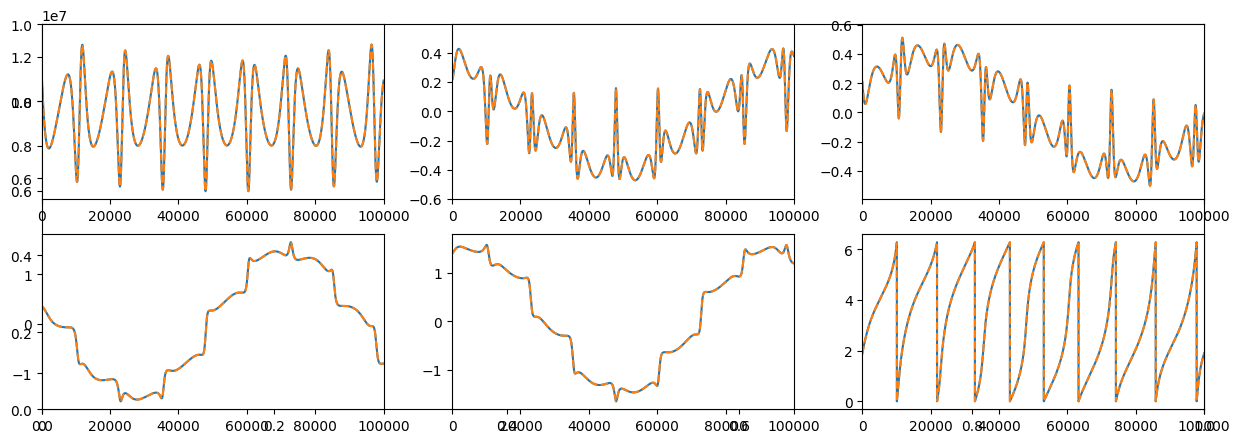

In [14]:
xmaxplt = 100000

plt.subplots(figsize=(15, 5))
plt.subplot(2, 3, 1)
plt.plot(t*T_dim, sol[:, 0]*L_dim, label='p(t)')
plt.plot(t_data, equi_data[:, 0], label='p_data(t)', linestyle='dashed')
plt.xlim([0, xmaxplt])

plt.subplot(2, 3, 2)
plt.plot(t*T_dim, sol[:, 1], label='f(t)')
plt.plot(t_data, equi_data[:, 1], label='f_data(t)', linestyle='dashed')
plt.xlim([0, xmaxplt])

plt.subplot(2, 3, 3)
plt.plot(t*T_dim, sol[:, 2], label='g(t)')
plt.plot(t_data, equi_data[:, 2], label='g_data(t)', linestyle='dashed')
plt.xlim([0, xmaxplt])

plt.subplot(2, 3, 4)
plt.plot(t*T_dim, sol[:, 3], label='h(t)')
plt.plot(t_data, equi_data[:, 3], label='h_data(t)', linestyle='dashed')
plt.xlim([0, xmaxplt])

plt.subplot(2, 3, 5)
plt.plot(t*T_dim, sol[:, 4], label='k(t)')
plt.plot(t_data, equi_data[:, 4], label='k_data(t)', linestyle='dashed')
plt.xlim([0, xmaxplt])

plt.subplot(2, 3, 6)
plt.plot(t*T_dim, np.mod(sol[:, 5],2*np.pi), label='l(t)')
plt.plot(t_data, equi_data[:, 5], label='l_data(t)', linestyle='dashed')
plt.xlim([0, xmaxplt])

Depending on your luck with `PySR`, you may get a perfect match!
If not, you will see that it is at least getting something close.

# Comparison of the forecast

Now, the aim of the hackathon is to forecast the orbit at time, sampled per second, from 2017-01-07 00:00:00 to 2017-01-11 00:00:00.

Let's do this projection starting from the given initial condition, which is the last time point of the training dataset.

In [15]:
t_forecast = np.linspace(0, 345600.0, 345600+1)/T_dim # time (s) - projection from 2017-01-07 00:00:00 to 2017-01-11 00:00:00, sampled per second

# Initial condition for forecast
IC = equi_data[-1]
IC[0] = IC[0] / L_dim  # Non-dimensionalize semi-parameter by Re

# Propagate
sol_forecast = odeint(dequi_dt, IC, t_forecast, rtol=1e-10)
sol_forecast[...,0] = sol_forecast[...,0]*L_dim  # Re-dimensionalize semi-parameter by Re

# Convert Equinoctial elements to Cartesian coordinates
r_forecast, v_forecast = equinoctial2ijk(sol_forecast, mu) # Might take 1-2 minutes to run

Let's import the actual trajectory from 2017-01-07 00:00:00 and compare how well we did

In [16]:
import pandas as pd
# Load the CSV file with correct column extraction
# Assuming the first column is time, next three are position (r1, r2, r3), last three are velocity (v1, v2, v3)
df = pd.read_csv('./data/Challenge1_wForecast.csv', header=0, usecols=[0,1,2,3,4,5,6], names=['time','r1', 'r2', 'r3', 'v1', 'v2', 'v3'])

# Extract position and velocity arrays
# Convert time strings to pandas datetime
t_raw = pd.to_datetime(df['time'])
t_start = pd.to_datetime('2017-01-07 00:00:00')
# Calculate seconds relative to the first time point
t_ans = (t_raw - t_start).dt.total_seconds().values # Time in seconds relative to first time point
r_ans = df[['r1', 'r2', 'r3']].values
v_ans = df[['v1', 'v2', 'v3']].values

# Isolate the forecast portion
r_ans = r_ans[t_ans >= 0]
v_ans = v_ans[t_ans >= 0]
t_ans = t_ans[t_ans >= 0]


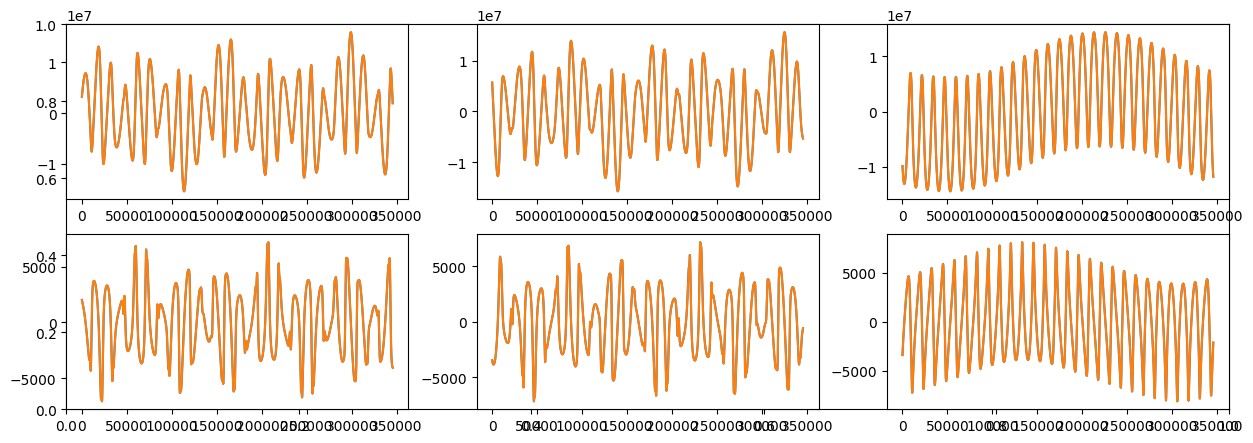

In [17]:
plt.subplots(figsize=(15, 5))
plt.subplot(2, 3, 1)
plt.plot(t_forecast*T_dim, r_forecast[:,0], label='r1_forecast')
plt.plot(t_ans, r_ans[:,0], label='r1_actual')
plt.subplot(2, 3, 2)
plt.plot(t_forecast*T_dim, r_forecast[:,1], label='r2_forecast')
plt.plot(t_ans, r_ans[:,1], label='r2_actual')
plt.subplot(2, 3, 3)
plt.plot(t_forecast*T_dim, r_forecast[:,2], label='r3_forecast')
plt.plot(t_ans, r_ans[:,2], label='r3_actual')
plt.subplot(2, 3, 4)
plt.plot(t_forecast*T_dim, v_forecast[:,0], label='v1_forecast')
plt.plot(t_ans, v_ans[:,0], label='v1_actual')
plt.subplot(2, 3, 5)
plt.plot(t_forecast*T_dim, v_forecast[:,1], label='v2_forecast')
plt.plot(t_ans, v_ans[:,1], label='v2_actual')
plt.subplot(2, 3, 6)
plt.plot(t_forecast*T_dim, v_forecast[:,2], label='v3_forecast')
plt.plot(t_ans, v_ans[:,2], label='v3_actual')


Did you get a good match?